# 🌍 Descarga de NDVI/NDWI desde Google Earth Engine (GEE)

En esta sección se descargarán variables de teledetección provenientes de **MODIS** utilizando la plataforma Google Earth Engine y el paquete `geemap`.

### 📦 Variables consideradas:

- **NDVI** – Índice de Vegetación de Diferencia Normalizada  
  - Fuente: MODIS  
  - Descripción: Representa la cantidad y vigor de vegetación verde.  
  - Aplicación: Análisis de cobertura vegetal, estrés hídrico, productividad.  

- **NDWI** – Índice de Diferencia Normalizada de Humedad  
  - Fuente: MODIS  
  - Descripción: Estima el contenido de agua en vegetación o cuerpos de agua superficiales.  
  - Aplicación: Monitoreo de humedad del suelo, zonas inundadas o estrés hídrico.

Estas variables se generarán a partir de productos MODIS, utilizando combinaciones específicas de bandas, y se exportarán en formato raster `.tif`, ya recortadas al área de interés definida en el shapefile del **Valle del Cauca**.


# 🧠 Carga de funciones del proyecto

En esta sección se importan todas las funciones necesarias que han sido previamente desarrolladas en los scripts del proyecto:

- ☀️ `download.copernicus`  
  Funciones para descargar datos climáticos desde Copernicus (temperatura, radiación, humedad, etc.).

- 🔧 `download.utils`  
  Funciones utilitarias como:
  - Verificación de conexión a Internet
  - Validación de archivos descargados
  - Registro de logs

- 🛠 `download.process`  
  Funciones de procesamiento espacial de los datos, incluyendo:
  - `descomprimir_archivo_gz()` → descomprime archivos `.gz` en formatos `.tif` o `.nc`
  - `recortar_raster()` → recorta un raster con shapefile o bounding box

Estas funciones encapsulan toda la lógica del pipeline para mantener el notebook limpio, modular y reutilizable.

In [2]:
# Importación paquetes
import ee
import geemap
import subprocess
import sys
from pathlib import Path
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import box
from datetime import date, timedelta
import zipfile

# Ruta base: carpeta raíz del proyecto (2 niveles arriba del notebook)
ruta_base = Path.cwd().parent.resolve()
sys.path.append(str(ruta_base))

# Confirmar que el path es correcto
print(f"Ruta base del proyecto agregada a sys.path: {ruta_base}")

# Importación de funciones de descarga y procesamiento
from download.process import descomprimir_archivo_gz, recortar_raster, extract_zip_flat
from download.gee import descargar_ndvi_modis,descargar_ndwi_modis
from download.utils import log_event


Ruta base del proyecto agregada a sys.path: D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader


## 🔐 Autenticación con Google Earth Engine (solo la primera vez)

Google Earth Engine requiere autenticación la primera vez que se usa.  
Este proceso abrirá una pestaña en el navegador para iniciar sesión con tu cuenta de Google.

Después de autenticarse una vez, el token se guarda localmente y ya no es necesario repetir este paso.


In [7]:
import ee
from pathlib import Path

def autenticar_ee():
    """
    Inicializa Earth Engine, autenticando solo si es necesario o si falla.
    """
    credenciales_path = Path.home() / ".config" / "earthengine" / "credentials"

    try:
        # Intentar inicializar directamente
        ee.Initialize()
        print("✅ Earth Engine ya estaba autenticado e inicializado.")
    except ee.EEException as e:
        print("🔐 Autenticación requerida para Earth Engine.")
        print("📂 Revisando si existe archivo de credenciales:", credenciales_path)

        if not credenciales_path.exists():
            print("⚠️ No se encontró archivo de credenciales. Lanzando autenticación...")
        else:
            print("⚠️ Archivo de credenciales existe pero no es válido. Re-autenticando...")

        ee.Authenticate()
        ee.Initialize()
        print("🌍 Earth Engine autenticado e inicializado correctamente.")

# Llamar a la función
autenticar_ee()

🔐 Autenticación requerida para Earth Engine.
📂 Revisando si existe archivo de credenciales: C:\Users\dagudelo\.config\earthengine\credentials
⚠️ Archivo de credenciales existe pero no es válido. Re-autenticando...



Successfully saved authorization token.
🌍 Earth Engine autenticado e inicializado correctamente.


## 📍 Área de interés y configuración global de fechas

En esta sección se define la configuración **base** que será utilizada por todas las funciones de descarga a lo largo del notebook:

- **Área de interés (AOI)**:  
  Se carga el shapefile del departamento **Valle del Cauca**, ubicado en `data/auxiliary/shapefiles/valle/valle.shp`.  


- **Rango de fechas**:  
  Se establece un rango temporal definido por `fecha_inicio` y `fecha_fin`, con un intervalo diario.  
  Este rango será reutilizado para construir las fechas de descarga para **CHIRPS**.

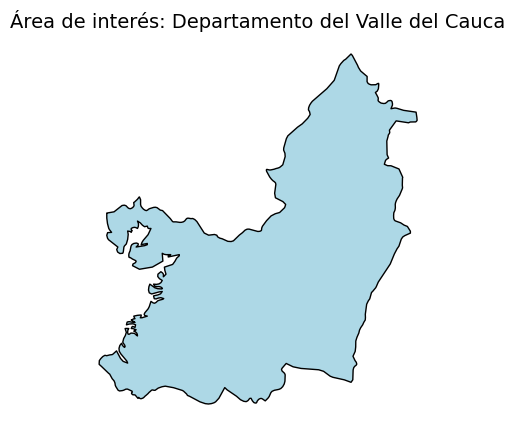

📅 Fecha de inicio de descarga: 2014-01-01
📅 Fecha de fin de descarga:    2014-05-31


In [24]:
# 📍 Cargar shapefile del Valle del Cauca
shapefile_valle = ruta_base / "data" / "auxiliary" / "shapefiles" / "valle" / "valle.shp"
gdf_valle = gpd.read_file(shapefile_valle)

# 🗺️ Visualizar el área de interés
fig, ax = plt.subplots(figsize=(5, 5))
gdf_valle.plot(ax=ax, color='lightblue', edgecolor='black')
ax.set_title("Área de interés: Departamento del Valle del Cauca", fontsize=14)
ax.set_axis_off()
plt.show()

# 📆 Rango de fechas de descarga
fecha_inicio = date(2014, 1, 1)
fecha_fin = date(2014, 5, 31)

print(f"📅 Fecha de inicio de descarga: {fecha_inicio.strftime('%Y-%m-%d')}")
print(f"📅 Fecha de fin de descarga:    {fecha_fin.strftime('%Y-%m-%d')}")

In [12]:

RAW_GEE = ruta_base / "data" / "raw" / "gee"
INTERIM_GEE = ruta_base / "data" / "interim" / "gee"
PROCESSED_GEE = ruta_base / "data" / "processed" / "gee"

# Variables a descargar desde Google Earth Engine
gee_variables = ["NDVI", "NDWI"]

# Diccionarios para rutas por variable
RAW_GEE_VARS = {}
INTERIM_GEE_VARS = {}
PROCESSED_GEE_VARS = {}

# Crear subcarpetas organizadas por variable
for var in gee_variables:
    var_folder = var.upper()

    raw_path = RAW_GEE / var_folder
    interim_path = INTERIM_GEE / var_folder
    processed_path = PROCESSED_GEE / var_folder

    # Crear carpetas si no existen
    for path in [raw_path, interim_path, processed_path]:
        path.mkdir(parents=True, exist_ok=True)

    # Guardar rutas en diccionarios
    RAW_GEE_VARS[var] = raw_path
    INTERIM_GEE_VARS[var] = interim_path
    PROCESSED_GEE_VARS[var] = processed_path

print("✅ Carpetas para NDVI y NDWI (GEE) creadas correctamente.")

✅ Carpetas para NDVI y NDWI (GEE) creadas correctamente.


##  Descarga de NDVI

In [21]:
# 📥 Descarga de NDVI MODIS para el Valle del Cauca
print("🌱 Iniciando descarga de NDVI desde MODIS...")
print(f"🗓️ Rango de fechas: {fecha_inicio.strftime('%Y-%m-%d')} a {fecha_fin.strftime('%Y-%m-%d')}")
print(f"📍 Shapefile AOI: {shapefile_valle}")
print(f"📁 Carpeta de salida: {PROCESSED_GEE_VARS['NDVI']}")

descargar_ndvi_modis(
    fecha_inicio=fecha_inicio.strftime("%Y-%m-%d"),
    fecha_fin=fecha_fin.strftime("%Y-%m-%d"),
    shapefile_path=str(shapefile_valle),
    output_folder=str(PROCESSED_GEE_VARS["NDVI"])
)

🌱 Iniciando descarga de NDVI desde MODIS...
🗓️ Rango de fechas: 2022-10-11 a 2022-10-22
📍 Shapefile AOI: D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\auxiliary\shapefiles\valle\valle.shp
📁 Carpeta de salida: D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\processed\gee\NDVI
📦 Imágenes encontradas: 0


ValueError: ⚠ No se encontraron imágenes para el rango de fechas y la región seleccionada.

##  Descarga de NDWI

In [25]:
# 📥 Descarga de NDWI MODIS para el Valle del Cauca
print("🌱 Iniciando descarga de NDWI desde MODIS...")
print(f"🗓️ Rango de fechas: {fecha_inicio.strftime('%Y-%m-%d')} a {fecha_fin.strftime('%Y-%m-%d')}")
print(f"📍 Shapefile AOI: {shapefile_valle}")
print(f"📁 Carpeta de salida: {PROCESSED_GEE_VARS['NDWI']}")

descargar_ndwi_modis(
    fecha_inicio=fecha_inicio.strftime("%Y-%m-%d"),
    fecha_fin=fecha_fin.strftime("%Y-%m-%d"),
    shapefile_path=str(shapefile_valle),
    output_folder=str(PROCESSED_GEE_VARS["NDWI"])
)

🌱 Iniciando descarga de NDWI desde MODIS...
🗓️ Rango de fechas: 2014-01-01 a 2014-05-31
📍 Shapefile AOI: D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\auxiliary\shapefiles\valle\valle.shp
📁 Carpeta de salida: D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\processed\gee\NDWI
📦 Imágenes encontradas: 151
Generating URL ...
Please wait ...
Data downloaded to D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\processed\gee\NDWI\NDWI_MODIS_2014-01-01.tif
✅ Descargado: D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\processed\gee\NDWI\NDWI_MODIS_2014-01-01.tif
Generating URL ...
Please wait ...
Data downloaded to D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\processed\gee\NDWI\NDWI_MODIS_2014-01-02.tif
✅ Descargado: D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\processed\gee\NDWI\NDWI_MODIS_2014-01-02.tif
Generating URL ...
Please wait ...
Data do